# [Making backpropagation simple again](https://learnml.today/making-backpropagation-autograd-mnist-classifier-from-scratch-in-Python-5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

**Backpropagation** (backward propagation of errors) -  is a widely used algorithm in training feedforward networks. It computes the gradient of the loss function with respect to the weights of the network. The main idea of it is to break big functions in small parts and use partial derivatives to get function derivative with using the Chain Rule. 

So training the model is basically solving this equation:

\begin{equation}
loss(model(X), Target) = 0
\end{equation}

And because solving this can be a very hard task, here comes backpropagation and gradient descent(updating weights by a small amount based on the gradient to move in the way of loss minimization).

All this is based on a simple diferentiation chain rule:

\begin{equation}
\frac{df}{dx} = \frac{df}{dy}*\frac{dy}{dx}  
\end{equation}

For example we have simple function with 2 nodes(operation):

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/Circuit1.png?raw=true" />

Let's say we have 3 variables x=-2, y=5, z=-4, the result will be f=-12, and our target for training is -13.
Simple loss=f-target=1.

Now we need to propagate our error(1) back to the x,y,z. To do this we will need to calculate partial derivatives for every function(operation):

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/SimpleGraph.png?raw=true" />

\begin{equation}
Multiplication:\\
(q * z)dq = 1 * z \\
(q * z)dz = q * 1 \\
Summation:\\
(x + y)dx = 1 \\
(x + y)dy = 1
\end{equation}

And our chain is:
\begin{equation}
\frac{df}{dx} = 1*(z*loss(1)) = 1 * -4 * 1 = -4 \\
\frac{df}{fy} = 1*(z*loss(1)) = 1 * -4 * 1 = -4 \\
\frac{df}{dz} = q*loss(1) = 3 * 1 = 3 \\
\end{equation}


## Let's build simple Autograd example
Here we will build a simple automatic diferentiation example from the above formulas.

In [2]:
class Tensor:

    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.requires_grad = requires_grad
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

class Op:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out


class AddOp(Op):

    '''Sumation operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()


class MulOp(Op):

    '''Multiplication operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()


Now let's see what will happens

In [3]:
x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = Tensor(x,requires_grad=True)
_a = Tensor(a,requires_grad=True)
_b = Tensor(b,requires_grad=True)

# here we use parameter _a 2 times in different operations.
# that means that gradient will be calculated twice for _a.
# and thus we need to sum two gradients to get result 
# gradient for _a
y = MulOp()(
        AddOp()(
            MulOp()(
                _x, _a
            ), _b
        ), _a
    )
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(Tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  Tensor([[0.16024811 0.57438545 0.03090806]
 [0.40163313 0.22264702 0.5241381 ]
 [0.87644898 0.04202385 0.49834653]])

y.grad_fn =  <__main__.MulOp object at 0x0000013D25435570>

_x.grad =  Tensor([[1.92424535e-03 5.27494984e-02 2.85210917e-04]
 [5.87713733e-02 6.01070339e-02 2.48760324e-01]
 [5.45211624e-01 8.51257857e-03 1.42302890e-01]])

_a.grad =  Tensor([[0.06170527 0.12869522 0.1778978 ]
 [0.61302352 0.17751863 1.17982675]
 [1.66414241 0.46067687 0.48846533]])

_b.grad =  Tensor([[0.90644599 0.29624334 0.75457986]])

y.grad =  None


Checking with PyTorch Autograd

In [4]:
_x = torch.tensor(x,requires_grad=True)
_a = torch.tensor(a,requires_grad=True)
_b = torch.tensor(b,requires_grad=True)
y = (_a*_x + _b) * _a
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(torch.tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  tensor([[0.1602, 0.5744, 0.0309],
        [0.4016, 0.2226, 0.5241],
        [0.8764, 0.0420, 0.4983]], dtype=torch.float64, grad_fn=<MulBackward0>)

y.grad_fn =  <MulBackward0 object at 0x0000013D25435B40>

_x.grad =  tensor([[1.9242e-03, 5.2749e-02, 2.8521e-04],
        [5.8771e-02, 6.0107e-02, 2.4876e-01],
        [5.4521e-01, 8.5126e-03, 1.4230e-01]], dtype=torch.float64)

_a.grad =  tensor([[0.0617, 0.1287, 0.1779],
        [0.6130, 0.1775, 1.1798],
        [1.6641, 0.4607, 0.4885]], dtype=torch.float64)

_b.grad =  tensor([0.9064, 0.2962, 0.7546], dtype=torch.float64)

y.grad =  None


c:\Users\andre\anaconda3\envs\dfwpythoneer_deeplearning\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\b\abs_f0dma8qm3d\croot\pytorch_1669187301762\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


As you can se we got the same gradients as in our simple autograd solution

## Let's build Neural Networks and solve 2 simple tasks
For simplicity we will not use autograd here and will solve derivative for each layer.

In [5]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input


        

Now when we construct our layers let's build some models :)

## Running simple point interpolation

In [6]:
class Model(Layer):

    def __init__(self, lr=0.0001):
        self.lr = lr
        self.layers = [
            Linear(3,15, lr=self.lr),
            Relu(),
            Linear(15,1, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

mm = Model()

def yf(x1,x2,x3):
    return np.array([2 * x1 + 3*x2 + 4*x3 + 5],dtype=np.float32)

loss = MSE()

for i in range(20000):
    x1 = np.random.random()*30
    x2 = np.random.random()*20
    x3 = np.random.random()*11
    y = mm(np.array([[x1,x2,x3]]))
    err = loss(y, yf(x1,x2,x3))
    
    yb = loss.backward()
    yb = mm.backward(yb)
    if i % 100 == 0:
        print(err)
        print('VAL Target:',yf(1,2,3), 'Res:',mm(np.array([[1,2,3]])), 'Loss:',loss(yf(1,2,3), mm(np.array([[1,2,3]]))))
        print('---------')

[[3269.92316547]]
VAL Target: [25.] Res: [[5.39420253]] Loss: [[192.19364724]]
---------
[[0.11292696]]
VAL Target: [25.] Res: [[19.06087512]] Loss: [[17.63660215]]
---------
[[3.44039726]]
VAL Target: [25.] Res: [[22.07691501]] Loss: [[4.27221293]]
---------
[[1.67987768]]
VAL Target: [25.] Res: [[23.31261113]] Loss: [[1.4236406]]
---------
[[0.00577138]]
VAL Target: [25.] Res: [[23.20536622]] Loss: [[1.6103552]]
---------
[[1.68378019]]
VAL Target: [25.] Res: [[23.30145482]] Loss: [[1.44252786]]
---------
[[0.00058026]]
VAL Target: [25.] Res: [[23.28782111]] Loss: [[1.46577828]]
---------
[[0.66359774]]
VAL Target: [25.] Res: [[23.19564337]] Loss: [[1.62785142]]
---------
[[1.31050077]]
VAL Target: [25.] Res: [[23.44038488]] Loss: [[1.21619966]]
---------
[[0.02746258]]
VAL Target: [25.] Res: [[23.32343059]] Loss: [[1.40544249]]
---------
[[0.15604121]]
VAL Target: [25.] Res: [[23.3396938]] Loss: [[1.37830834]]
---------
[[1.20503588]]
VAL Target: [25.] Res: [[23.11590555]] Loss: [[1

## Classifying MNIST with our custom network
Now let's solve some classification task on MNIST dataset.
We will use some PyTorch utils to make it simpler

In [7]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')
            


100%|██████████| 9912422/9912422 [00:01<00:00, 9892101.50it/s] 


Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 7177560.81it/s]

Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3991269.05it/s]


Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 2998666.58it/s]


Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist\MNIST\raw

0.24758380309447955
---------
140.27075367201897
---------
136.56154590355524
---------
116.26543782899597
---------
119.13950510821574
---------
117.51334623624281
---------
102.91815913117007
---------
124.90970467159077
---------
106.41662492525556
---------
102.33590571189005
---------
98.88113242946069
---------
90.1256865998381
---------
86.9376525610599
---------
91.40137242934827
---------
91.29177787869871
---------
82.59429503699687
---------
83.27396636428166
---------
87.18127779530741
---------
76.33111819441442
---------
69.751944788744
---------
72.8797666355245
---------
75.59140127691849
---------
79.48781560579683
---------
77.84185142663686
---------
79.62623370548837
---------
76.32125341958604
---------
71.18763103014652
---------
69.9926988272353
---------
71.64411511813626
---------
73.32135245004443
---------
66.44950182926368
---------
69.97331790111554
---------
62.473782034477935
---

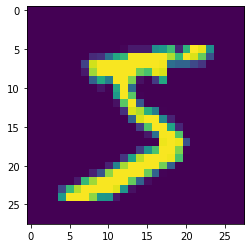

target: 5 predicted: 5


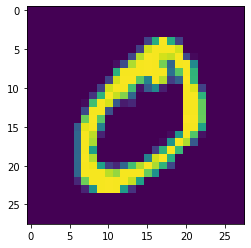

target: 0 predicted: 0


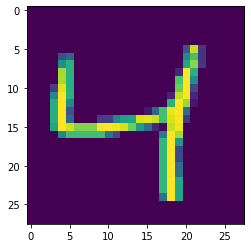

target: 4 predicted: 4


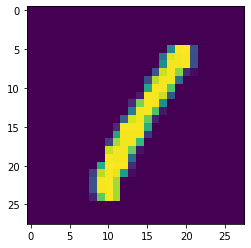

target: 1 predicted: 1


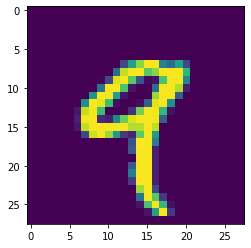

target: 9 predicted: 9


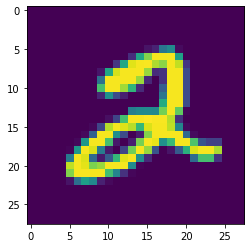

target: 2 predicted: 2


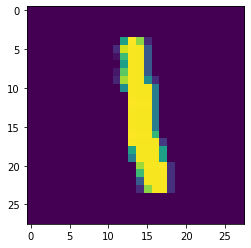

target: 1 predicted: 1


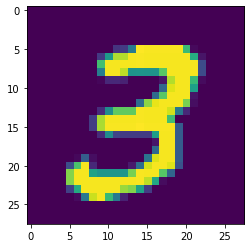

target: 3 predicted: 3


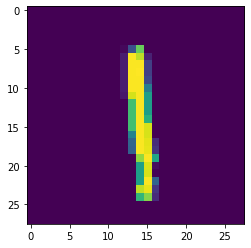

target: 1 predicted: 1


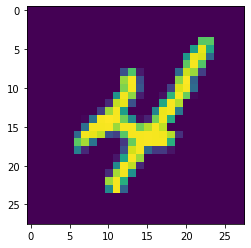

target: 4 predicted: 4


In [8]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )

### If you want to learn more -> subscribe to our Object Detection Course or Newsletter [LearnML.Today](https://learnml.today)

In [11]:
torch.save(mm, 'mnist_dynamic.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1, 1, 28, 28).to(device)
input_names = [ "input_0" ]
output_names = [ "output_0" ]
torch.onnx.export(mm, dummy_input, 'mnist_dynamic.onnx', verbose=True, input_names=input_names, output_names=output_names)

AttributeError: 'Model' object has no attribute 'training'

In [16]:
torch.onnx._export(mm,dummy_input, 'mnist_dynamic.onnx', verbose=True, input_names=input_names, output_names=output_names)

AttributeError: 'Model' object has no attribute 'training'

In [17]:
mm.training

AttributeError: 'Model' object has no attribute 'training'

In [14]:
model = mm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## utility function to compute accuracy
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## commence training
    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))


AttributeError: 'Model' object has no attribute 'to'